# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import tensorflow as tf

print (tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Change current working directory to project folder (1 mark)

In [3]:
import os
os.chdir('.')
print (os.curdir)

.


### Load the "images.npy" file (4 marks)
- This file contains images with details of bounding boxes

In [4]:
import numpy as np
data = np.load('images.npy', allow_pickle=True)
print (len (data))

409


### Check one sample from the loaded "images.npy" file  (4 marks)

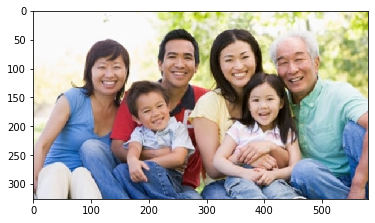

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.5586206896551724, 'y': 0.19938650306748465}, {'x': 0.6603448275862069, 'y': 0.3773006134969325}], 'imageWidth': 580, 'imageHeight': 326}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.38620689655172413, 'y': 0.18711656441717792}, {'x': 0.4896551724137931, 'y': 0.4049079754601227}], 'imageWidth': 580, 'imageHeight': 326}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.1724137931034483, 'y': 0.23006134969325154}, {'x': 0.2775862068965517, 'y': 0.44171779141104295}], 'imageWidth': 580, 'imageHeight': 326}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.7155172413793104, 'y': 0.19938650306748465}, {'x': 0.8448275862068966, 'y': 0.41411042944785276}], 'imageWidth': 580, 'imageHeight': 326}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.2982758620689655, 'y': 0.44171779141104295}, {'x': 0.4189655172413793, 'y': 0.6533742331288344}], 'imageWidth': 580, 'imageHeight': 326}, {'label': ['Face'], 'notes': '', 'points': [{'

In [5]:
import matplotlib.pyplot as plt

plt.imshow(data[4,0])
plt.show()

print (data[4,1])

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [6]:
IMAGE_WIDTH =224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [7]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1


### Print the shape of X_train and mask array  (1 mark)

In [8]:
#### Add your code here ####
print (X_train.shape)
print (masks.shape)

(409, 224, 224, 3)
(409, 224, 224)


In [9]:
masks[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


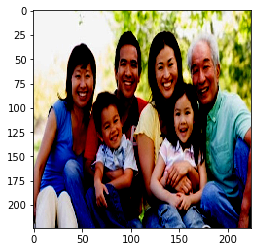

In [10]:
from matplotlib import pyplot
n = 4
pyplot.imshow(X_train[n])

(224, 224)


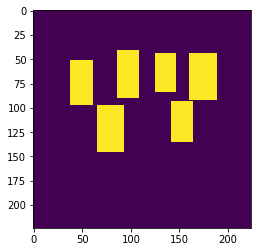

In [11]:
pyplot.imshow(masks[n])
print (masks[n].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


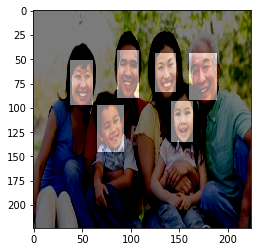

In [12]:
pyplot.imshow(X_train[n])
pyplot.imshow(masks[n,:, :], cmap='gray', alpha=0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


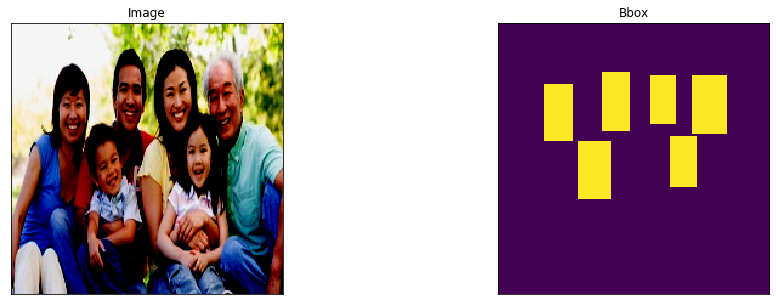

In [13]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
visualize(image = X_train[n],
         bbox = masks[n].squeeze())    

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [42]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Concatenate, Conv2D, Conv2DTranspose, UpSampling2D, Reshape, BatchNormalization, Activation
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import epsilon
from tensorflow.keras.models import Model

ALPHA = 1.0

def create_model(trainable=True):
    model = MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), 
                        include_top=False, 
                        alpha=ALPHA, 
                        weights="imagenet")
    
    # set all layers of model to be non-trainable
    model.trainable = False
       
    # Fine-tune from this layer onwards
    fine_tune_after = 150

    print ('Number of layers in mobilenetv2 model is %d'%(len(model.layers)))
    print ('Number of layers in mobilenetv2 model to be trained is %d'%(len(model.layers[fine_tune_after:])))
    
    # enable last six layers which are to be fine-tuned
    for layer in model.layers[fine_tune_after:]:
        layer.trainable = trainable

    # Use the activations of these layers
    layer_names = [
        'block_1_expand',   # 112x112
        'block_2_expand',   # 56x56
        'block_6_expand',   # 28x28
        'block_13_expand',  # 14x14
        'block_16_project', # 7x7
    ]
       
    # Add all the UNET layers here
    layers = [model.get_layer(name).output for name in layer_names]
    
    print (layers)
    x = layers[-1]
    layers=reversed(layers[:-1])
    
    for layer in layers:
        x = UpSampling2D()(x)
        x = Concatenate()([x, layer])    
        
    x = Conv2D(256, kernel_size=3, padding="same", strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=3, padding="same", strides=1)(x)
    x = Activation("sigmoid")(x)
    
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    #x = Reshape((4,))(x) #
    
    print ('Final layer after convolution->',x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [43]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(True)

# Print summary
model.summary()

Number of layers in mobilenetv2 model is 155
Number of layers in mobilenetv2 model to be trained is 5
[<tf.Tensor 'block_1_expand_3/Identity:0' shape=(None, 112, 112, 96) dtype=float32>, <tf.Tensor 'block_2_expand_3/Identity:0' shape=(None, 56, 56, 144) dtype=float32>, <tf.Tensor 'block_6_expand_3/Identity:0' shape=(None, 28, 28, 192) dtype=float32>, <tf.Tensor 'block_13_expand_3/Identity:0' shape=(None, 14, 14, 576) dtype=float32>, <tf.Tensor 'block_16_project_3/Identity:0' shape=(None, 7, 7, 320) dtype=float32>]
Final layer after convolution-> Tensor("activation_7/Identity:0", shape=(None, 224, 224, 1), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [44]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

    return numerator / (denominator + epsilon())

### Define loss

In [69]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

def loss(y_true, y_pred):    
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (5 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [70]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[])

Tensor("activation_7_target_2:0", shape=(None, None, None, None), dtype=float32)
Tensor("activation_7/Identity:0", shape=(None, 224, 224, 1), dtype=float32)


### Define checkpoint and earlystopping

In [71]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)

stop = EarlyStopping(monitor="loss", patience=5, mode="min")

reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [89]:
EPOCHS = 25
MULTI_PROCESSING = False
THREADS = 1

history = model.fit(X_train, 
                      masks, 
                      epochs=EPOCHS,
                      callbacks=[checkpoint, reduce_lr, stop],
                      batch_size=1,
                      shuffle=True,
                      workers=THREADS,
                      use_multiprocessing=MULTI_PROCESSING,
                      verbose=1)

Train on 409 samples
Epoch 1/25
Tensor("Cast_1:0", shape=(1, 224, 224), dtype=float32)
Tensor("loss/activation_7_loss/remove_squeezable_dimensions/Squeeze:0", shape=(1, 224, 224), dtype=float32)
407/409 [============================>.] - ETA: 0s - loss: 9.6187
Epoch 00001: loss did not improve from 9.43647
409/409 [==============================] - 16s 39ms/sample - loss: 9.6130
Epoch 2/25
407/409 [============================>.] - ETA: 0s - loss: 9.5668
Epoch 00002: loss did not improve from 9.43647
409/409 [==============================] - 14s 34ms/sample - loss: 9.5674
Epoch 3/25
407/409 [============================>.] - ETA: 0s - loss: 9.5562
Epoch 00003: loss did not improve from 9.43647
409/409 [==============================] - 14s 35ms/sample - loss: 9.5520
Epoch 4/25
407/409 [============================>.] - ETA: 0s - loss: 9.5554
Epoch 00004: loss did not improve from 9.43647
409/409 [==============================] - 14s 35ms/sample - loss: 9.5410
Epoch 5/25
407/409 [====

### Get the predicted mask for a sample image   (5 marks)

### Impose the mask on the image (5 marks)

In [90]:
#### Add your code here ####

IMAGE_SIZE=224
n = 4

test_image = X_train[n]
test_image = cv2.resize(test_image, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
feat_scaled = preprocess_input(np.array(test_image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled])) # Predict the BBox
region = region.reshape(1,224,224)

print (region)
for i in range(1):
    for j in range(224):
        for k in range (224):
            if (region[i][j][k] == 1):
                print ('yes!')

[[[1.1742852e-03 3.6414240e-05 6.2339219e-05 ... 4.4993201e-04
   4.7499372e-04 2.3718374e-03]
  [1.1736727e-04 7.6276274e-07 2.9256416e-06 ... 2.3214292e-05
   1.3234291e-05 9.8975986e-05]
  [9.6481825e-05 3.5172584e-07 1.4977547e-06 ... 3.6323403e-05
   1.3493985e-05 1.0946264e-04]
  ...
  [1.9593458e-04 4.9016916e-07 1.7396538e-06 ... 1.6592265e-05
   9.4638235e-06 1.9216778e-04]
  [5.2845274e-04 2.2289557e-06 6.9672315e-06 ... 4.1259587e-05
   2.5111363e-05 3.6328915e-04]
  [3.1496556e-03 1.3498234e-04 2.6575857e-04 ... 1.6726617e-03
   1.1046618e-03 1.4356052e-02]]]


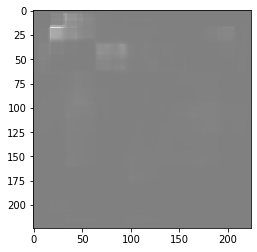

In [91]:
#plt.imshow(test_image)
pyplot.imshow(region[0,:, :], cmap='gray', alpha=0.5)
plt.show()

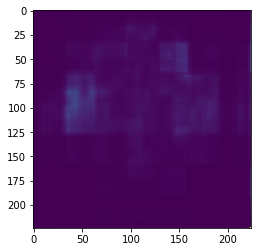

In [88]:
pyplot.imshow(region[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


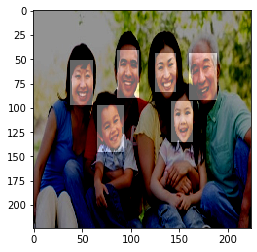

In [57]:
plt.imshow(X_train[n])
pyplot.imshow(masks[n,:, :], cmap='gray', alpha=0.4)
plt.show()